Implementation of baseline Model for Emotion Detection in RAVDESS Dataset

In [1]:
import os
import cv2

Creating an array containing paths of training data

In [7]:
actors = [os.path.join('RAVDESS/Train', f) for f in os.listdir('RAVDESS/TRAIN')]
train_videos = []
for actor in actors:
    train_videos.extend([os.path.join(actor, f) for f in os.listdir(actor) if f[-8] == '1'])

In [4]:
import numpy as np

Note: only one of the two following snippets are to be executed

First snippet, face detection + a basic face-align transformation

For each video, the frames are taken and the face is detected using pre-trained Haar cascade models,\
The face is aligned, such that the eyes are at the same level, and finally this image (cropped so as to include face only) is resized to 128x128.\
Now, since there are multiple frames per video, the train_data is an array of arrays, where each array represents a frame, and set of arrays represents a video.\
Furthermore, for the chi-squared SVM kernel, the dimensions of each video must be same, so on an average (roughly) 100 frames of each video are considered, and padding is done in case frames are less.

In [12]:
import cv2
import numpy as np

# Load Haar cascades for face and eyes
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

def align_face_with_eyes(frame, face_cascade, eye_cascade, size=(128, 128)):
    grey_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect face
    faces = face_cascade.detectMultiScale(grey_frame, scaleFactor=1.1, minNeighbors=3, minSize=(50, 50))
    if len(faces) == 0:
        return None  # No face detected
    
    # Select the largest detected face
    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
    eyes = eye_cascade.detectMultiScale(grey_frame, scaleFactor=1.1, minNeighbors=3, minSize=(5, 5))
    if len(eyes) < 2:
        return None
    eyes = sorted(eyes, key=lambda rect: rect[2] * rect[3], reverse=True)[:2]
    eye_centers = [(x + ex + ew // 2, y + ey + eh // 2) for ex, ey, ew, eh in eyes]
    eye_centers = sorted(eye_centers, key=lambda p: p[0])
    left_eye, right_eye = eye_centers

    # Compute angle of rotation
    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    face_center = (float(x + w / 2), float(y + h / 2))

    rotation_matrix = cv2.getRotationMatrix2D(face_center, angle, 1.0)
    rotated_frame = cv2.warpAffine(grey_frame, rotation_matrix, (frame.shape[1], frame.shape[0]))
    aligned_face = rotated_frame[y:y + h, x:x + w]
    aligned_face = cv2.resize(aligned_face, size)
    return aligned_face

train_data = []
train_labels = []

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
num_frames = 100

for vid in train_videos[0:300]:
    videocap = cv2.VideoCapture(vid)
    face_array = []

    while videocap.isOpened():
        ret, framecap = videocap.read()
        if not ret:
            break

        aligned_face = align_face_with_eyes(framecap, face_cascade, eye_cascade)
        face_array.append(aligned_face)

        if len(face_array) >= num_frames:
            break

    videocap.release()

    while len(face_array) < num_frames:
        face_array.append(np.zeros((128, 128), dtype=np.uint8))  # Padding with black frames

    # Convert to numpy array
    frames = np.array(face_array)  # Ensure consistent dtype
    label = vid[-17]  # Extract label
    train_data.append(frames)
    train_labels.append(label)



In case face alignment (with reference to eyes), is not done, and only face detection is applied.\
Note: Since Intraface library (mentioned for the baseline model) is not available anymore, the face alignment step is applied only at a fundamental level (and just applies an affine transformation/rotation). However, this step doesn't really affect the accuracy that much since in-depth feature extraction isn't really occuring here (Intraface not used). So, with only face detection as well, the result for chi-squared SVM is similar.

In [70]:
train_data = []
train_labels = []

cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
num_frames = 100

for vid in train_videos[0:300]:
    videocap = cv2.VideoCapture(vid)
    face_array = []

    while videocap.isOpened():
        ret, framecap = videocap.read()
        if not ret:
            break
        grey = cv2.cvtColor(framecap, cv2.COLOR_BGR2GRAY)
        faces = cascade.detectMultiScale(grey, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))
        if len(faces) > 0:
            face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = face
            cropface = grey[y:y + h, x:x + w]
            resized_face = cv2.resize(cropface, (128, 128))
            face_array.append(resized_face)

        if len(face_array) >= num_frames:
            break

    videocap.release()
    while len(face_array) < num_frames:
        face_array.append(np.zeros((128, 128), dtype=np.uint8))

    frames = np.array(face_array)
    label = vid[-17]
    train_data.append(frames)
    train_labels.append(label)



LBP-TOP features are extracted using the lbp function, by splitting image/frame into blocks of 4x4. calculating the feature vector, and for each indivdual frame, the final feature vector is the combined flattened vector of each block.

In [13]:
from skimage.feature import local_binary_pattern
def split_blocks(frame):
    blocks = []
    for i in range(0,128, 4):
        for j in range(0,128, 4):
            blck = frame[i:i+4, j:j+4]
            lbp = local_binary_pattern(blck,8,1,method='uniform')
            blocks.append(lbp.flatten())

    features = np.concatenate(blocks)
    return features

In [14]:
features = []
for data in train_data:   
    frame_feat = [] 
    for frame in data:
        feat = split_blocks(frame)
        frame_feat.append(feat)
    features.append(frame_feat)

Storing the features in a pickle file

In [15]:
import pickle
with open('aligned_features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Calculating the Kernel Matrix for chi-squared SVM and training the svm

In [ ]:
flattened_features = np.array(features)
kernel_matrix = np.zeros((len(flattened_features), len(flattened_features)))
for i, x in enumerate(flattened_features):
    for j, y in enumerate(flattened_features):
        kernel_matrix[i, j] = np.sum(((x - y) ** 2) / (x + y + 1e-9))

train_k = np.exp(-1 * kernel_matrix)

svm = SVC(kernel='precomputed', C=1.0)  # C is the regularization parameter
svm.fit(train_k, train_labels)

SVC(kernel='precomputed')

In [75]:
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

Extracting the features for test data, in a similar fashion as for training data\
Note: The first code block does a basic face-align as well, and second one implements only face detection. Using only face detection one will suffice for this as well.

In [18]:
actors = [os.path.join('RAVDESS/Test', f) for f in os.listdir('RAVDESS/Test')]
test_videos = []
for actor in actors:
    test_videos.extend([os.path.join(actor, f) for f in os.listdir(actor) if f[-8] == '1'])

test_data = []
test_labels = []

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
num_frames = 100

for vid in test_videos[0:120]:
    videocap = cv2.VideoCapture(vid)
    face_array = []

    while videocap.isOpened():
        ret, framecap = videocap.read()
        if not ret:
            break

        # Align the face using eyes
        aligned_face = align_face_with_eyes(framecap, face_cascade, eye_cascade)
        if aligned_face is not None:
            face_array.append(aligned_face)

        if len(face_array) >= num_frames:
            break

    videocap.release()

    # Ensure the number of frames is consistent
    while len(face_array) < num_frames:
        face_array.append(np.zeros((128, 128), dtype=np.uint8))  # Padding with black frames

    # Convert to numpy array
    frames = np.array(face_array)  # Ensure consistent dtype
    label = vid[-17]  # Extract label
    test_data.append(frames)
    test_labels.append(label)

test_features = []
for data in test_data:   
    frame_feat = [] 
    for frame in data:
        feat = split_blocks(frame)
        frame_feat.append(feat)
    test_features.append(frame_feat)

Only face detection snippet

In [76]:
actors = [os.path.join('RAVDESS/Test', f) for f in os.listdir('RAVDESS/Test')]
test_videos = []
for actor in actors:
    test_videos.extend([os.path.join(actor, f) for f in os.listdir(actor) if f[-8] == '1'])

test_data = []
test_labels = []

cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
num_frames = 100

for vid in test_videos[0:120]:
    videocap = cv2.VideoCapture(vid)
    face_array = []

    while videocap.isOpened():
        ret, framecap = videocap.read()
        if not ret:
            break
        grey = cv2.cvtColor(framecap, cv2.COLOR_BGR2GRAY)
        faces = cascade.detectMultiScale(grey, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))
        if len(faces) > 0:
            face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = face
            cropface = grey[y:y + h, x:x + w]
            resized_face = cv2.resize(cropface, (128, 128))
            face_array.append(resized_face)

        if len(face_array) >= num_frames:
            break

    videocap.release()
    while len(face_array) < num_frames:
        face_array.append(np.zeros((128, 128), dtype=np.uint8))

    frames = np.array(face_array)
    label = vid[-17]
    test_data.append(frames)
    test_labels.append(label)

test_features = []
for data in test_data:   
    frame_feat = [] 
    for frame in data:
        feat = split_blocks(frame)
        frame_feat.append(feat)
    test_features.append(frame_feat)

In [79]:
with open('test_features.pkl', 'wb') as f:
    pickle.dump(test_features, f)

In [17]:
with open('svm_model.pkl','rb') as f:
    svm = pickle.load(f)

Results

In [18]:
test_feat = np.array(test_features)
test_kernel_matrix = np.zeros((len(test_feat), len(flattened_features)))
for i, x in enumerate(test_feat):
    for j, y in enumerate(flattened_features):
        test_kernel_matrix[i, j] = np.sum(((x - y) ** 2) / (x + y + 1e-9))

test_k = np.exp(-1 * test_kernel_matrix)

y_pred = svm.predict(test_k)
print(f"Accuracy: {accuracy_score(test_labels, y_pred):.2f}")

Accuracy: 0.13


C:\Users\Tanish Verma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 13.33%
Precision: 0.02
Recall: 0.13
F1 Score: 0.03


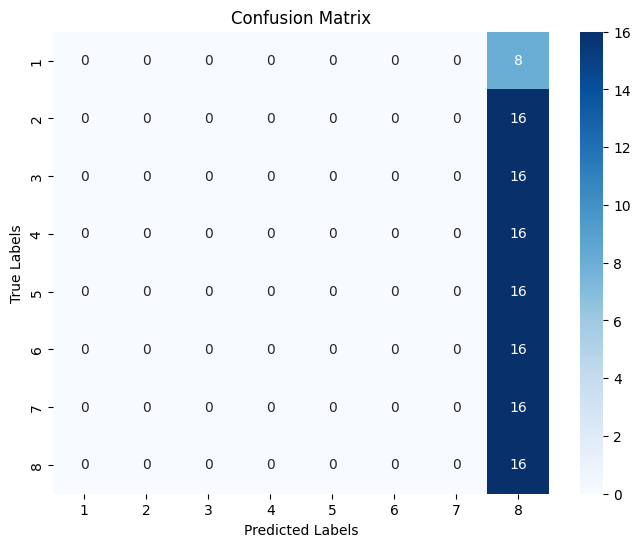

In [19]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average="weighted")
recall = recall_score(test_labels, y_pred, average="weighted")
f1 = f1_score(test_labels, y_pred, average="weighted")
conf_matrix = confusion_matrix(test_labels, y_pred)

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(test_labels),
    yticklabels=np.unique(test_labels),
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


We can observe from the confusion matrix that this SVM approach doesn't correctly classify the multimodal problem, since only the 8th label is getting predicted.\
Therefore, instead of chi-squared we will use a RBF kernel for this.

In [8]:
train_labels = []
for vid in train_videos[0:300]:
    label = vid[-17]  # Extract label
    train_labels.append(label)

Using RBF kernel, for the SVM\
For this we are using aggregated features instead, so each video now is represented by a mean frame.

In [10]:
import pickle
with open('features.pkl','rb') as f:
    features = pickle.load(f)

from sklearn.svm import SVC
aggregated_features = []

for video_features in features:
    # Video features: (num_frames, feature_vector_size)
    video_features = np.array(video_features)
    # Aggregate features using mean
    aggregated_feature = video_features.mean(axis=0)  # Shape: (feature_vector_size,)
    aggregated_features.append(aggregated_feature)

aggregated_features = np.array(aggregated_features)
train_labels = np.array(train_labels)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
aggregated_features = scaler.fit_transform(aggregated_features)

svm = SVC(kernel='rbf', C=1.0, gamma='scale') 
svm.fit(aggregated_features, train_labels)


SVC()

In [11]:
actors = [os.path.join('RAVDESS/Test', f) for f in os.listdir('RAVDESS/Test')]
test_videos = []
for actor in actors:
    test_videos.extend([os.path.join(actor, f) for f in os.listdir(actor) if f[-8] == '1'])

test_labels = []
for vid in test_videos[0:120]:
    label = vid[-17]  # Extract label
    test_labels.append(label)

test_labels = np.array(test_labels)

In [13]:
test_aggregated_features = []
with open('test_features.pkl','rb') as f:
    test_features = pickle.load(f)

for video_features in test_features:
    # Video features: (num_frames, feature_vector_size)
    video_features = np.array(video_features)
    # Aggregate features using mean
    test_aggregated_feature = video_features.mean(axis=0)  # Shape: (feature_vector_size,)
    test_aggregated_features.append(test_aggregated_feature)

test_aggregated_features = np.array(test_aggregated_features)  # Shape: (num_videos, feature_vector_size)
test_aggregated_features = scaler.transform(test_aggregated_features)

y_pred = svm.predict(test_aggregated_features)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 0.20%


C:\Users\Tanish Verma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 20.00%
Precision: 0.17
Recall: 0.20
F1 Score: 0.15


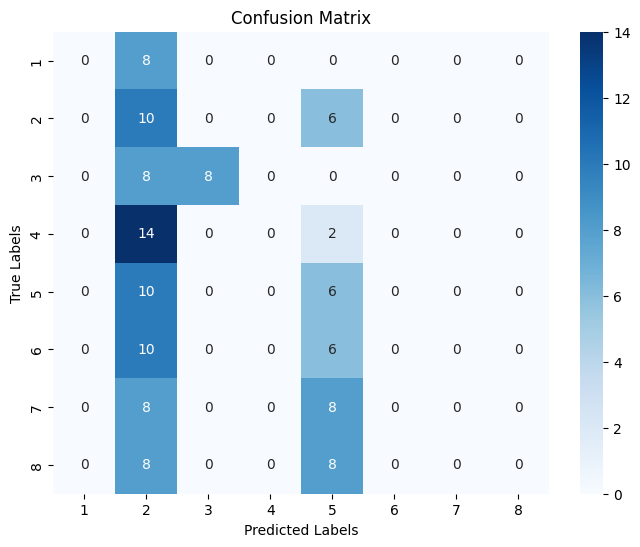

In [16]:
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average="weighted")
recall = recall_score(test_labels, y_pred, average="weighted")
f1 = f1_score(test_labels, y_pred, average="weighted")
conf_matrix = confusion_matrix(test_labels, y_pred)

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(test_labels),
    yticklabels=np.unique(test_labels),
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

This does a better job than chi-squared SVM, but still there is much disparity.